In [7]:
import xlwings as xw
from pathlib import Path
import pandas as pd
import time
from tqdm import trange

# ================== CONFIG ==================
N_RUNS = 1000

CREST_FILE = Path(r"E:\CREST Model\CREST_Demand_Model_v2.3.3.xlsm")

OUTPUT_DIR = Path(
    r"E:\GitHubProjects\LV network\Input data\Hotwater"
)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_CSV = OUTPUT_DIR / "crest_hotwater_all_runs_wd_rural.csv"

MAIN_SHEET = "Main Sheet"
OUTPUT_SHEET = "Results - disaggregated"

MACRO_NAME = "RunSimulationButton_Click"

# minute-resolution hot water volume
DATA_RANGE = "O7:O1446"   # 1440 rows
# ============================================

# ================== EXCEL APP ==================
app = xw.App(visible=False, add_book=False)
app.display_alerts = False
app.screen_updating = False

wb = app.books.open(CREST_FILE)

ws_main = wb.sheets[MAIN_SHEET]
ws_out  = wb.sheets[OUTPUT_SHEET]

run_macro = wb.macro(MACRO_NAME)

# ================== STORAGE ==================
all_runs = []

# ================== BATCH RUN ==================
for i in trange(N_RUNS, desc="CREST simulations", unit="run"):
    # reset stop flag (safety)
    ws_main["J18"].value = ""

    # run CREST
    run_macro()

    # make sure Excel finishes
    app.calculate()
    time.sleep(0.2)

    # read output
    demand = ws_out[DATA_RANGE].value

    # store as Series
    all_runs.append(
        pd.Series(demand, name=f"run_{i}")
    )

# ================== CLEANUP ==================
wb.close()
app.quit()

# ================== COMBINE & SAVE ==================
df = pd.concat(all_runs, axis=1)

# optional: add time index (minutes of day)
df.index = range(1, 1441)
df.index.name = "minute"

df.to_csv(OUTPUT_CSV)

print(f"✅ CREST batch generation completed")
print(f"📄 Saved to: {OUTPUT_CSV}")


CREST simulations: 100%|██████████| 1000/1000 [30:47<00:00,  1.85s/run]


✅ CREST batch generation completed
📄 Saved to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_hotwater_all_runs_wd_rural.csv


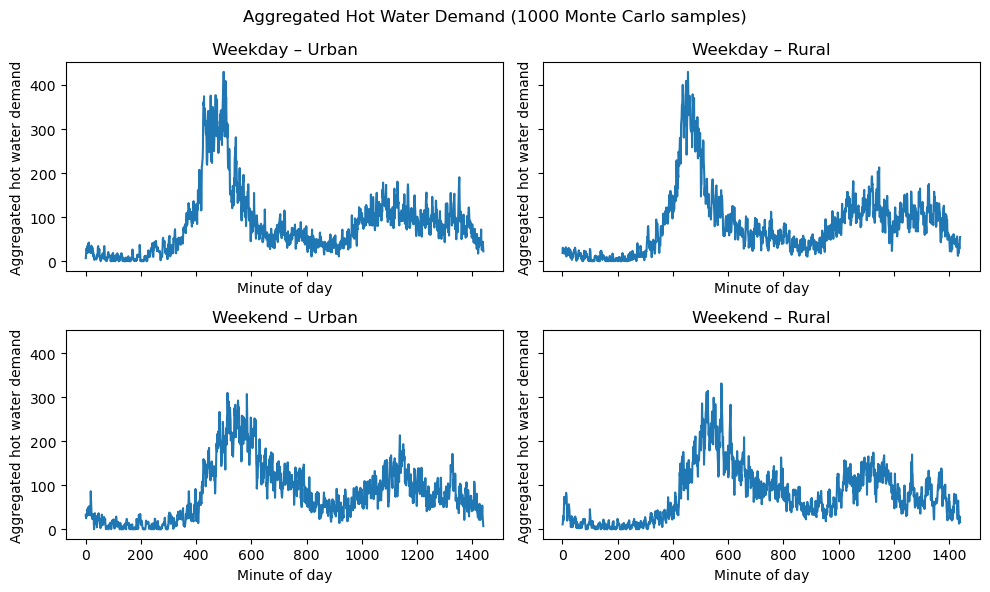

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ================== CONFIG ==================
BASE_DIR = Path(
    r"E:\GitHubProjects\LV network\Input data\Hotwater"
)

FILES = [
    ("Weekday – Urban",  BASE_DIR / "crest_hotwater_all_runs_wd_urban.csv"),
    ("Weekday – Rural",  BASE_DIR / "crest_hotwater_all_runs_wd_rural.csv"),
    ("Weekend – Urban",  BASE_DIR / "crest_hotwater_all_runs_we_urban.csv"),
    ("Weekend – Rural",  BASE_DIR / "crest_hotwater_all_runs_we_rural.csv"),
]

N_SAMPLES = 1000
# ============================================


# ---------------- CREATE SUBPLOTS ----------------
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 6))
axes = axes.flatten()

for ax, (title, path) in zip(axes, FILES):
    # read csv
    df = pd.read_csv(path, index_col="minute")

    # safety check
    if df.shape[1] < N_SAMPLES:
        raise ValueError(f"{title}: not enough Monte Carlo samples")

    # select Monte Carlo runs
    df_mc = df.iloc[:, :N_SAMPLES]

    # aggregate across runs
    agg_hotwater = df_mc.sum(axis=1)

    # plot
    ax.plot(agg_hotwater)
    ax.set_title(title)
    ax.set_xlabel("Minute of day")
    ax.set_ylabel("Aggregated hot water demand")

# ---------------- FINAL LAYOUT ----------------
fig.suptitle("Aggregated Hot Water Demand (1000 Monte Carlo samples)")
plt.tight_layout()
plt.show()
